# MODELO JA TREINADO

# Recarregamento do modelo treinado

In [14]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import io
import pandas as pd
import cv2
import sklearn
import random
from osgeo import gdal
import shutil

In [15]:
DATA_PATH = "D:/cbers_data/DataSetModelo/"
RAW_DATA_DIR = "D:/cbers_data/DataSetModelo/raw_scene/"
RAW_MASK_DIR = "D:/cbers_data/DataSetModelo/raw_mask/"
CLIPPED_DATA_DIR = "D:/cbers_data/DataSetModelo/clip/"
VRT_DATA_DIR = "D:/cbers_data/DataSetModelo/vrt/"
PREDICT_DIR = "D:/cbers_data/DataSetModelo/predict/"
DIMENSION = 256

# Functions

In [16]:
def resize_img(image,x,y,z):
    image = cv2.resize(image,(x,y))
    image = image.reshape((x,y,z))
    return image

def print_cbers_image(image):
    plt.figure()
    plt.imshow(image)
    plt.show()

In [17]:
def clip_image(input_path, output_path,image_name):
    red = gdal.Open(input_path + image_name + '_BAND13_GRID_SURFACE.tif')
    green = gdal.Open(input_path + image_name + '_BAND14_GRID_SURFACE.tif')
    blue = gdal.Open(input_path + image_name + '_BAND15_GRID_SURFACE.tif')
    #nir = gdal.Open(input_path + image_name + '_BAND16_GRID_SURFACE.tif')
    #Create the .vrt from RGBN
    #array = [red, green, blue,/nir]#adicionar o nir
    array = [red, green, blue]#adicionar o nir
    opt = gdal.BuildVRTOptions(srcNodata=-9999, VRTNodata=-9999,separate=True,resampleAlg='nearest')
    vrt_clip = gdal.BuildVRT(VRT_DATA_DIR + image_name +'.vrt', array, options=opt)
    #Translate the .vrt to .tif
    trans_opt = gdal.TranslateOptions(format="tif", outputType=gdal.gdalconst.GDT_Unknown, 
                                  bandList=[1,2,3],width=0, height=0, widthPct=0.0, 
                                  heightPct=0.0, xRes=0.0, yRes=0.0,noData=-9999)
    #Clip da imagem
    gdal.Translate(output_path + image_name +'_rgbn.tif', vrt_clip)
    #Apaga o vrt
    #os.remove(image_name + ".vrt") 
    return True
    

In [18]:
def crop_image_rgbn(output_dir, rgbn, image_name, dimension):
    gt = rgbn.GetGeoTransform()
    x_min = gt[0]
    y_max = gt[3]

    res = gt[1]

    num_img_x = rgbn.RasterXSize/dimension
    num_img_y = rgbn.RasterYSize/dimension

    x_len = res * rgbn.RasterXSize
    y_len = res * rgbn.RasterYSize

    x_size = x_len/num_img_x
    y_size = y_len/num_img_y


    x_steps = [x_min + x_size * i for i in range(int(num_img_x) + 1)]
    y_steps = [y_max - y_size * i for i in range(int(num_img_y) + 1)]
    print("qnt img x: " + str(num_img_x))
    print("qnt img y: " + str(num_img_y))
    index_img = 0
    for i in range(int(num_img_x)):
        for j in range(int(num_img_y)):
            x_min = x_steps[i]
            x_max = x_steps[i+1]
            y_max = y_steps[j]
            y_min = y_steps[j+1]
            index_img+=1
            
            gdal.Warp(output_dir + image_name+ "_" + str(i)+ "_" +str(j)+'_'+str(index_img)+"_"+".tif", rgbn, 
                      outputBounds = (x_min,y_min,x_max, y_max), dstNodata = -9999)

In [19]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Load model and predict

In [20]:
import glob
TESTE_FRAME_DIR = 'D:/cbers_data/DataSetModelo/CALIBRATING_MODEL/Training/test_frames/'
TESTE_MASK_DIR = 'D:/cbers_data/DataSetModelo/CALIBRATING_MODEL/Training/test_masks/'
# Load image

test_frames_list = glob.glob(TESTE_FRAME_DIR + "CBERS_4A_WFI_20201020_205_116_L4_*_*_*_*_.tif")
test_masks_list = glob.glob(TESTE_MASK_DIR + "CBERS_4A_WFI_20201020_205_116_L4_*_*_*_*_.tif")

In [21]:
QNT_SUB_FRAMES = len(test_frames_list)
test_images = np.zeros((QNT_SUB_FRAMES,DIMENSION,DIMENSION,4))

for i, ele in enumerate(test_frames_list):
    image_test = gdal.Open(ele).ReadAsArray()
    image_test = image_test.transpose((1,2,0))
    #image_test = cv2.normalize(image_test, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    test_images [i,:,:] = image_test
    #plt.imshow(tf.keras.preprocessing.image.array_to_img(image_test))
    #plt.show()

In [28]:
def createRGB(template,arr,filename):
    '''Creates a copy of a 3-band raster with values from array

    Arguments:

        template: Path to template raster
        arr: Value array with dimensions (r,c,3)
        filename: Output filename for new raster 
    '''

    # Open template
    t = gdal.Open(template)

    # Get geotiff driver
    driver = gdal.GetDriverByName('GTiff')

    # Create new raster
    r = driver.Create(filename, t.RasterXSize, t.RasterYSize, 3, gdal.GDT_Byte,['COMPRESS=LZW'])

    # Set metadata
    r.SetGeoTransform(t.GetGeoTransform())
    r.SetProjection(t.GetProjection())

    # loop through bands and write new values
    for bix in range(3):

        rb = r.GetRasterBand(bix+1)

        # Write array
        rb.WriteArray(arr[...,bix])

    # Close datasets
    t = None
    r = None
    rb = None

In [29]:
model = tf.keras.models.load_model('model', custom_objects={'f1':f1})

In [30]:
test_predicts = model.predict(test_images)

7/7 [==============================] - 49s 7s/step


In [31]:
#MOSTRA AS MASCARAS DAS IMAGENS
def show_mask(test_predicts):
    plt.figure(figsize=(5, 5))

    title = 'Predicted Mask'
    plt.title(title)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(test_predicts))
    plt.axis('off')
        
    plt.show()

In [32]:
#TRANSFORMA MASCARA OUTPUT EM RASTER
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()


In [33]:
for i, file_input in enumerate(test_frames_list):
    file_output = file_input.replace('test_frames','test_output')
    aux = gdal.Open(file_input)
    geo_t = aux.GetGeoTransform()
    origin = (geo_t[0],geo_t[3])
    px_width = geo_t[1]
    px_height = geo_t[5]
    array = test_predicts[i,:, :, 0]
    array2raster(file_output,origin,px_width,px_height,array)

In [34]:
for i, file_input in enumerate(test_frames_list):
    file_output = file_input.replace('test_frames','predict')

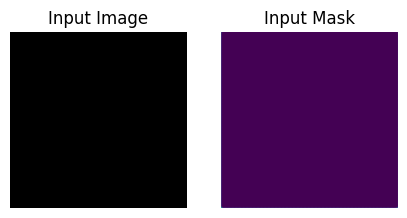

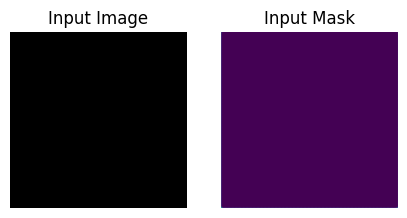

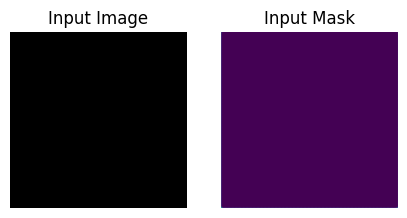

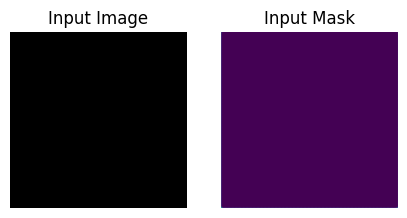

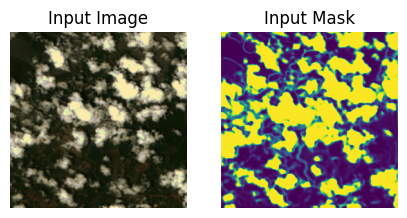

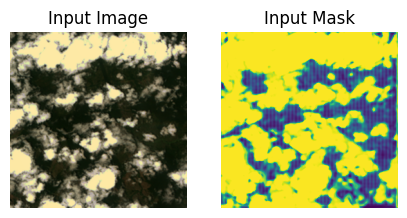

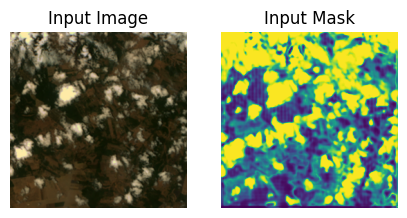

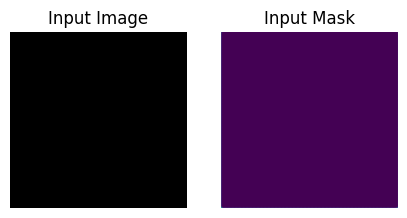

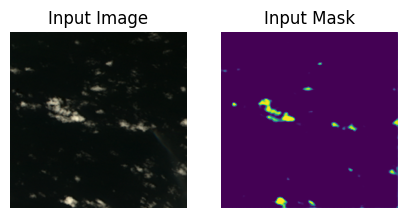

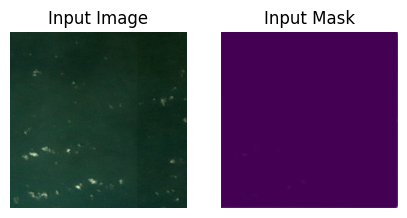

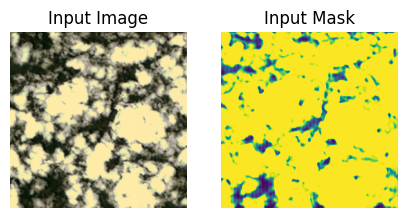

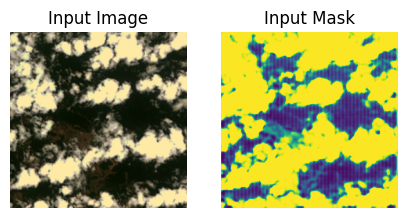

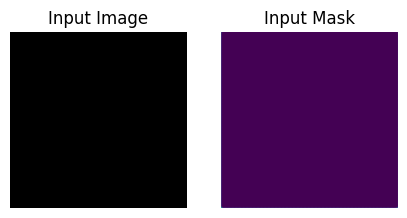

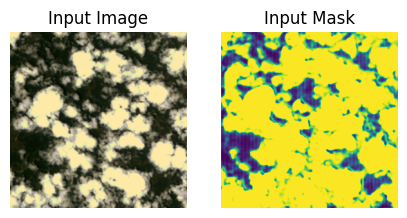

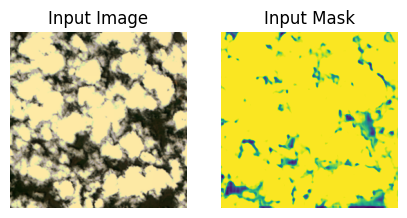

In [47]:
qnt_images = 15
for i in range(qnt_images):
    b, g, r  = test_images[i][:, :, 0], test_images[i][:, :, 1], test_images[i][:, :, 2]
    rgb = np.dstack((r,g,b))
    show_images([rgb, test_predicts[i]])

# Production

In [36]:
#dimensoes subscenes
DIMENSION = 256
BATCH_SIZE = 4

In [37]:
#CAMINHO DOS ARQUIVOS DE ENTRADA (IMAGEM COMPLETA) (ENTRADA)
production_frame_path = "D:/cbers_data/DataSetModelo/ProductionFrames/"

#CAMINHO QUE ARMAZENARÁ AS SUBCENAS DA IMAGEM DE ENTRADA (SAIDA)
production_cropped_frame_path = "D:/cbers_data/DataSetModelo/ProductionCroppedFrames/"

In [38]:
#Função responsável por cortar as imagens de entrada e salvá-las num diretório de saída
def save_cropped_production_images(input_path_base, output_path_base, DIMENSION):
    #Pega lista de imagens a serem cortadas
    raw_images_list_name = os.listdir(production_frame_path)
    for frame_name in raw_images_list_name:
        #Pasta de saída terá mesmo nome do arquivo de entrada (porém sem o .tif)
        output_path = output_path_base + frame_name.split('.')[0]+"/"
        #Caminho dos arquivos de entrada (imagens cruas)
        input_path = input_path_base + frame_name
        #Abre a imagem de entrada
        raw_scene = gdal.Open(input_path)
        #Cria uma pasta com o nome do arquivo de entrada
        if not os.path.isdir(output_path):
            os.mkdir(output_path)
        #Corta as imagens de entrada e as salva no diretório de saída
        crop_image_rgbn(output_path, raw_scene, frame_name.split(".")[0], DIMENSION)
        
#Chamada da função
save_cropped_production_images(production_frame_path,production_cropped_frame_path, DIMENSION)

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: 'D:/cbers_data/DataSetModelo/ProductionFrames/'

In [ ]:
#LISTA QUE CONTEM O CAMINHO DE CADA SUBCENA GERADA (ENTRADAS)
subscenes_path_list = [production_cropped_frame_path + file_name + "/" for file_name in os.listdir(production_cropped_frame_path)]

#CAMINHO QUE ARMAZENARÁ AS MASCARAS DAS SUBCENAS (SAIDA)
production_cropped_mask_path = "D:/cbers_data/DataSetModelo/ProductionCroppedMasks/"

In [ ]:
#Função responsável por chamar o modelo para gerar as mascaras e a salvar no diretório de saída
def save_production_cropped_masks(input_dir_list, output_path):
    #FOR que caminha entre os diretórios das subcenas
    for i, dir_name in enumerate(input_dir_list):
        #FOR que entrou no diretório de uma subcenas e caminha por elas
        input_file_list = os.listdir(dir_name)
        for j, file_name in enumerate(input_file_list):
            subscene = gdal.Open(dir_name+file_name)
            subscene_array = subscene.ReadAsArray().transpose((1,2,0))
            subscene_normalized =  cv2.normalize(subscene_array, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            #Dimensões são adequadas para o predict do modelo
            subscene_expanded = np.expand_dims(subscene_normalized, axis=0)
            subscene_mask = model.predict(subscene_expanded)
            
            ##Etapa para configurar o .tif das mascaras
            driver = gdal.GetDriverByName("GTiff")
            metadata = driver.GetMetadata()
            
            #Transforma shape da mascara de (1,256,256,1) para (256,256)
            subscene_mask = subscene_mask.squeeze()
            #NOME DA CENA ORIGINAL (IMAGEM INTEIRA)
            original_scene_name = file_name.split("rgbn")[0]+"rgbn"
            #Cria uma pasta com o nome do arquivo original (IMAGEM COMPLETA)
            if not os.path.isdir(output_path + original_scene_name):
                os.mkdir(output_path + original_scene_name)
            #Cria um raster (.tif) da mascara com o mesmo tamanho da subscena
            subscene_mask_raster = driver.Create(output_path + original_scene_name + "/" + file_name,
                                subscene.RasterXSize,
                                subscene.RasterYSize,
                                1, #Numero de bandas da mascara
                                gdal.GDT_Float32)
            #COPIA AS PROJEÇÕES DA SUBSCENA
            subscene_mask_raster.SetProjection(subscene.GetProjectionRef())
            subscene_mask_raster.SetGeoTransform(subscene.GetGeoTransform()) 
            
            #Get the band to write to
            #out_band = subscene.GetRasterBand(1)
            #ESCREVE A MASCARA EM DISCO
            subscene_mask_raster.WriteArray(subscene_mask)
            
save_production_cropped_masks(subscenes_path_list, production_cropped_mask_path)

In [ ]:
#LISTA QUE CONTEM O CAMINHO DE CADA MASCARA GERADA (ENTRADAS)
masks_path_list = [production_cropped_mask_path + file_name + "/" for file_name in os.listdir(production_cropped_mask_path)]


# Caminho para o diretório onde deverá ser salvo a máscara após o mosaico (SAIDA)
mask_mosaic_path = "D:/cbers_data/DataSetModelo/MergeFile/"

In [ ]:
for i, folder_name in enumerate(masks_path_list):
    folder_input_list = os.listdir(folder_name)
    files_to_mosaic_path = [folder_name + file_name  for file_name in folder_input_list]
    print(folder_input_list[0].split('rgbn')[0] + "rgbn/")
            

In [ ]:
import osgeo_utils.gdal_merge
def mount_mosaic_of_masks(input_path, output_path):
    for i, folder_name in enumerate(input_path):
        files_to_mosaic = os.listdir(folder_name)
        files_to_mosaic_path = [folder_name + file_name  for file_name in files_to_mosaic]
        #Cria uma pasta com o nome do arquivo original (IMAGEM COMPLETA)
        original_file_name = files_to_mosaic[0].split("rgbn")[0]+"rgbn"
        if not os.path.isdir(output_path + original_file_name):
            os.mkdir(output_path + original_file_name)
        #ESCREVE EM DISCO
        print(output_path + original_file_name + "/" + original_file_name + 
                      ".tif")
        g = gdal.Warp(output_path + original_file_name + "/" + original_file_name + 
                      ".tif", files_to_mosaic_path, format="GTiff")
        g = None # Close file and flush to disk
        
mount_mosaic_of_masks(masks_path_list, mask_mosaic_path)